**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Extract Stocks](#toc2_)    
  - 2.1. [Scraping Ticker-wise SubReddit](#toc2_1_)    
  - 2.2. [Scraping from different Subreddits](#toc2_2_)    
    - 2.2.1. [EDA](#toc2_2_1_)    
  - 2.3. [Pushshift API](#toc2_3_)    
  - 2.4. [Other Sources](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

.\venv\Scripts\activate

pip freeze > requirements.txt

In [2]:
import pandas as pd
import praw
import prawcore.exceptions
from datetime import datetime, timedelta
from psaw import PushshiftAPI
import seaborn as sns

# 2. <a id='toc2_'></a>[Extract Stocks](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Scraping Ticker-wise SubReddit](#toc0_)

In [5]:
# Initialize the Reddit API client
reddit = praw.Reddit(
    client_id="2aV6_rxA1c44CoHtxY6e0A",
    client_secret="7rbu00bmyQOlnHCu-xjyTa-U5har-g",
    user_agent="Project Capstone"
)

# Define a list of subreddits related to Google Stocks
subreddit_to_search = 'MSFT'

# Create an empty list to store post data
post_data = []

# Iterate through the subreddit
subreddit = reddit.subreddit(subreddit_to_search)

try:
    # Get the top posts from each subreddit
    top_posts = subreddit.top(time_filter="all", limit=None)

    # Iterate through the top posts and collect data
    for post in top_posts:
        post_data.append({
            'Subreddit': subreddit_to_search,
            'Title': post.title,
            'Author': str(post.author),
            'Score': post.score,
            'URL': post.url,
            'Content': post.selftext,
            'Post_Date': pd.to_datetime(post.created_utc, unit='s')
        })

except prawcore.exceptions.NotFound as e:
    print(f"Error in subreddit '{subreddit_to_search}': {e}")
    
except prawcore.exceptions.Forbidden as e:
    print(f"Access forbidden in subreddit '{subreddit_to_search}': {e}")
        
# Create a DataFrame from the collected data
df = pd.DataFrame(post_data)

# Sort by date
df = df.sort_values(by='Post_Date')

In [6]:
df

(9, 7)

Tickers and their counts:
- APPL (646,7)
- GOOG received 404 HTTP response 
- NFLX received 404 HTTP response
- TSLA (999,7)
- AMZN (94,7)
- MSFT (9,)

**Observations:-**

- **1. Need to extract top-n posts and their 'title' and 'selftext' based on 'score':**
  
  Most of the posts do contain important data in title as well. So, posts with only images can be considered if they have enough information in their title.
    
- **2. More quality posts in r/Stocks rather than specific r/AAPL, r/AMZN:**

  It is seen that each of these stocks contain only <=500 posts each spread across different days (no daily format). Fixed amount of posts (rows) per day as per the price data must be searched.
  Some dates start with 2015, some on 2020, and some on 2021.

## 2.2. <a id='toc2_2_'></a>[Scraping from different Subreddits](#toc0_)

In [134]:
## Code to scrape posts related to all stocks from different subreddits

# Define a list of subreddits to search for Apple Stocks-related posts
subreddits_to_search = ['stocks', 'investing', 'wallstreetbets', 'finance', 'economy', 'stockmarket', 'business']

# Define a list of search queries
search_queries = ['Apple Stocks OR AAPL', 'Google Stocks OR GOOG', 'Netflix Stocks OR NFLX', 'TESLA Stocks OR TSLA', 'Microsoft Stocks OR MSFT']

# Define the date range (January 1, 2015, to December 31, 2020) to match Twitter Data
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2020, 12, 31)

# Create lists to store data
titles = []
authors = []
scores = []
urls = []
contents = []
post_dates = []
subreddit_names = []
query_names = []

# Iterate through each subreddit in the list
for subreddit_name in subreddits_to_search:
    for search_query in search_queries:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            
            posts = subreddit.search(search_query, limit=None)

            # Iterate through the search results and collect data
            for post in posts:
                post_date = pd.to_datetime(post.created_utc, unit='s').date()
                if start_date <= post_date <= end_date:
                    if post.selftext:  # Check if the post has text content
                        titles.append(post.title)
                        authors.append(post.author)
                        scores.append(post.score)
                        urls.append(post.url)
                        contents.append(post.selftext)
                        post_dates.append(pd.to_datetime(post.created_utc, unit='s'))
                        subreddit_names.append(subreddit_name)
                        query_names.append(search_query[-4:])

        except prawcore.exceptions.NotFound as e:
            print(f"Error in subreddit '{subreddit_to_search}': {e}")
        except prawcore.exceptions.Forbidden as e:
            print(f"Access forbidden in subreddit '{subreddit_to_search}': {e}")
        except praw.exceptions.APIException as e:
            print(f"API Error: {e}")
            # Wait for a while before retrying (e.g., 5 seconds)
            time.sleep(5)

# Create a DataFrame
data = {
    'Query': query_names,
    'Subreddit': subreddit_names,
    'Title': titles,
    'Author': authors,
    'Score': scores,
    'URL': urls,
    'Content': contents,
    'Post_Date': post_dates,
}

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# drop duplicate
df = df.drop_duplicates(subset='URL')

# Sort by date
df = df.sort_values(by='Post_Date')

# Store as csv file
df.to_csv('Data\Reddit_AllStocks_DifferentSubreddits.csv')

Dataset link: https://drive.google.com/file/d/1J3_hWxuwdf69yuokEyhrzQklyqA1mHAO/view?usp=drive_link

In [135]:
df

,Query,Subreddit,Title,Author,Score,URL,Content,Post_Date
1224,AAPL,finance,Why does cost of equity really represent?,HanselGretel,5,https://www.reddit.com/r/finance/comments/2rp3...,I'm not sure this is the right sub for this qu...,2015-01-08 02:02:45
339,AAPL,investing,If you had to buy today 20 stocks which you co...,mimichicken,168,https://www.reddit.com/r/investing/comments/2r...,I am curious what the investor community in Re...,2015-01-10 05:25:07
878,MSFT,investing,What is the ONE stock you are most excited abo...,Iama_tomhanks,200,https://www.reddit.com/r/investing/comments/2s...,"No judging, you dicks.",2015-01-11 16:42:11
648,NFLX,investing,NFLX: Buy/Hold/Sell thoughts?,TRA8324,2,https://www.reddit.com/r/investing/comments/2s...,"domestic growth is definitely slowing, but can...",2015-01-12 20:48:03
1268,GOOG,finance,Anyone have the marketing/press documents ISIS...,Warhawk_1,3,https://www.reddit.com/r/finance/comments/2sgr...,"Was a doc 80-120 pages long, think it was for ...",2015-01-15 01:02:27
...,...,...,...,...,...,...,...,...
1298,GOOG,economy,"What do you think, could tesla stock collapse ...",jumplineg,0,https://www.reddit.com/r/economy/comments/knlf...,&#x200B;\n\nhttps://preview.redd.it/zuju24i54h...,2020-12-31 07:20:47
183,TSLA,stocks,Tesla Short Sellers Lost $38 Billion in 2020 a...,coolcomfort123,2493,https://www.reddit.com/r/stocks/comments/knqco...,https://www.bloombergquint.com/business/tesla-...,2020-12-31 13:52:20
656,TSLA,investing,Are there any historical examples of stocks be...,awokk,962,https://www.reddit.com/r/investing/comments/kn...,I think (most) people would agree that TSLA is...,2020-12-31 16:34:35
953,AAPL,wallstreetbets,AAPL is the 2021 Play,thinkclay,93,https://www.reddit.com/r/wallstreetbets/commen...,"Missed out on the TSLA run in 2020? Aww, that’...",2020-12-31 17:11:40


In [136]:
# Counts of Posts per stock
df['Query'].value_counts()

Query
NFLX    404
MSFT    325
AAPL    291
TSLA    285
GOOG    239
Name: count, dtype: int64

In [137]:
# Group the data by year and count the number of posts in each year for specified stocks
df[df['Query']=='AAPL']['Post_Date'].dt.year.value_counts().sort_index()

Post_Date
2015     29
2016     21
2017     12
2018     34
2019     37
2020    158
Name: count, dtype: int64

**Observations:-**

- **1. Same number of records per stock:**
  
  ***CORRECTION:*** if we remove duplicate posts based on URL, then the number of records to ~800

- **2. Specifying Date range doesn't work:** 
  
  Despite specifying Start amd End Date range, the post_date does contain other dates.
- **3. 15-20 posts per year for a stock:** 
  
  On average, there are ~15 posts per year.

- **4. More no. of posts after year 2020 for a stock:** 

  On average, there are >100 posts after year 2020.


### 2.2.1. <a id='toc2_2_1_'></a>[EDA](#toc0_)

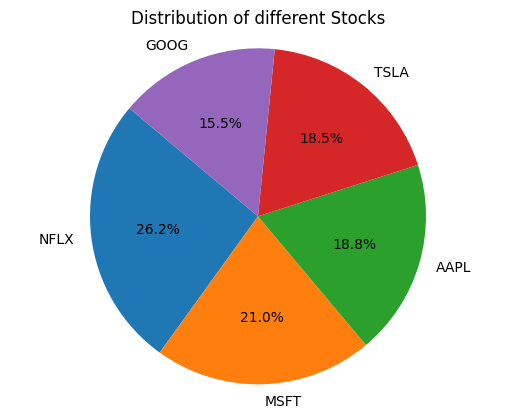

In [139]:
# EDA 1
# Create a pie chart
plt.pie(df['Query'].value_counts(), labels=df['Query'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of different Stocks')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Display the pie chart
plt.show()

All the stocks have significant and uniform percentage of distribution 

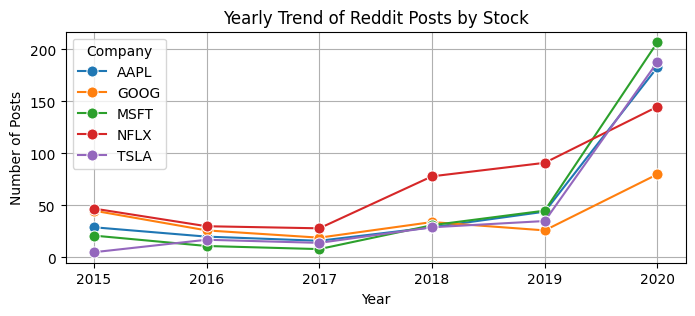

In [9]:
import matplotlib.pyplot as plt

df = pd.read_csv('Data/RedditPosts_Cleaned.csv')

df['Post_Date'] = df['Date']
df['Query'] = df['Stock']

# EDA 2
# Assuming you have a DataFrame 'df' with 'Company' and 'Post_Date' columns
# Convert 'Post_Date' to a datetime object if it's not already
df['Post_Date'] = pd.to_datetime(df['Post_Date'])

# Extract the year from the 'Post_Date' column
df['Year'] = df['Post_Date'].dt.year

# Group the data by 'Year' and 'Company' and count the number of posts in each group
yearly_counts = df.groupby(['Year', 'Query']).size().reset_index(name='Count')

# Create a line plot using seaborn
plt.figure(figsize=(8, 3))
sns.lineplot(data=yearly_counts, x='Year', y='Count', hue='Query', marker='o', markersize=8)

# Customize the plot
plt.title('Yearly Trend of Reddit Posts by Stock')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True)

# Show the legend
plt.legend(title='Company')

# Display the plot
plt.show()

We can clearly observe that the number of posts increase with years.
There is a step rise in no. of posts in 2020.

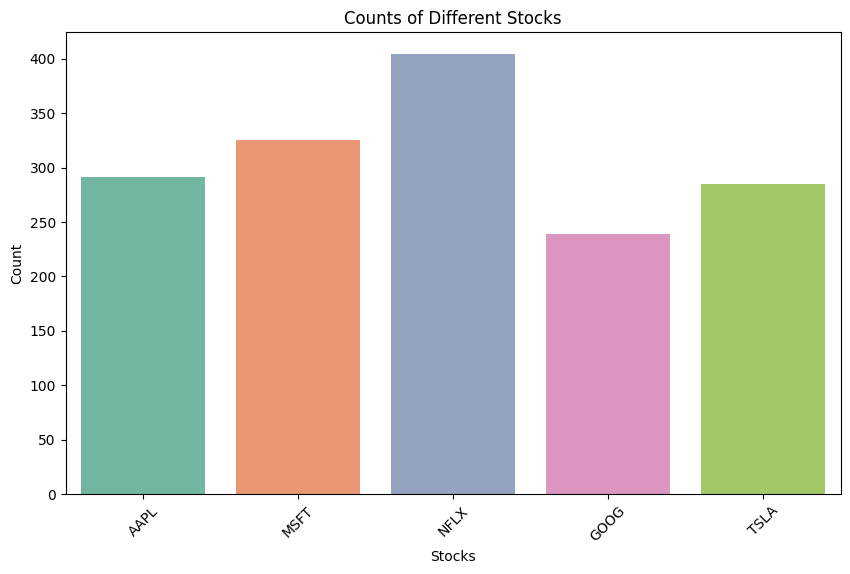

In [153]:
# EDA 3

# Create a count plot using seaborn, assigning 'x' to 'hue' and setting 'legend=False'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Query', hue='Query', palette='Set2', legend=False)  # Use a different color palette

# Customize the plot
plt.title('Counts of Different Stocks')
plt.xlabel('Stocks')
plt.ylabel('Count')

# Rotate x-axis labels for better readability (adjust the rotation angle as needed)
plt.xticks(rotation=45)

# Show the plot
plt.show()

NFLX has the most posts followed by others, all of them having >200 posts.

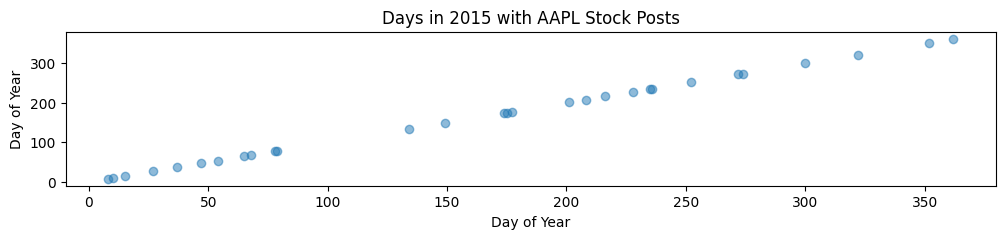

In [167]:
# EDA 4

# Filter the DataFrame for AAPL stock in the year 2015
aapl_2015 = df[(df['Query'] == 'AAPL') & (df['Post_Date'].dt.year == 2015)].copy()

# Extract the day of the year from the 'Post_Date' column
aapl_2015['Day_of_Year'] = aapl_2015['Post_Date'].dt.dayofyear

# Create a scatter plot
plt.figure(figsize=(12, 2))
plt.scatter(aapl_2015['Day_of_Year'], aapl_2015['Day_of_Year'], marker='o', alpha=0.5)
plt.title('Days in 2015 with AAPL Stock Posts')
plt.xlabel('Day of Year')
plt.ylabel('Day of Year')  # This label is just for demonstration

# Show the plot
plt.show()

We can see that there are less posts but, are spread out across the days in the year.

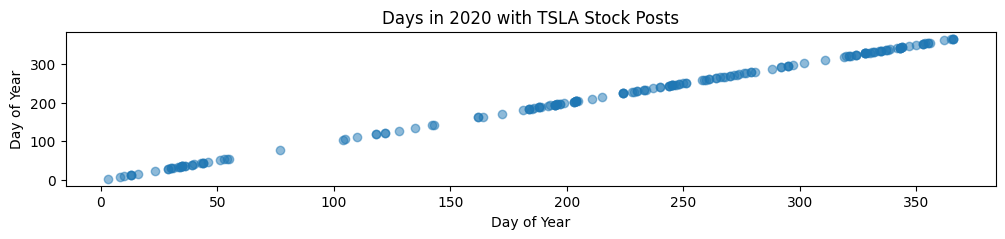

In [168]:
# EDA 5

# Filter the DataFrame for AAPL stock in the year 2015
tsla_2020 = df[(df['Query'] == 'TSLA') & (df['Post_Date'].dt.year == 2020)].copy()

# Extract the day of the year from the 'Post_Date' column
tsla_2020['Day_of_Year'] = tsla_2020['Post_Date'].dt.dayofyear

# Create a scatter plot
plt.figure(figsize=(12, 2))
plt.scatter(tsla_2020['Day_of_Year'], tsla_2020['Day_of_Year'], marker='o', alpha=0.5)
plt.title('Days in 2020 with TSLA Stock Posts')
plt.xlabel('Day of Year')
plt.ylabel('Day of Year')  # This label is just for demonstration

# Show the plot
plt.show()

We can see that there are more posts are spread out across the days in the year.

## 2.3. <a id='toc2_3_'></a>[Pushshift API](#toc0_)

1. Dump having Reddit comments and submissions from 2005-2022 collected by pushshift 
    
    Link: https://academictorrents.com/details/7c0645c94321311bb05bd879ddee4d0eba08aaee

2. Repository with links to Reddit dumps 
    
    Link: https://github.com/ArthurHeitmann/arctic_shift

In [ ]:
# Create an object of the API
api = PushshiftAPI()                                        

Output:-

- Exception: Unable to connect to pushshift.io. Max retries exceeded.

## 2.4. <a id='toc2_4_'></a>[Other Sources](#toc0_)

1. **Reddit_Sentiment_Trader**
    
    Link: https://github.com/tstewart161/Reddit_Sentiment_Trader/


2. **Reddit WallStreetBets:** 
    
    Link: Hype Stock Posts: https://www.kaggle.com/datasets/aaaaaaaaade/reddit-wallstreetbets-hype-stock-posts/data

    Dataset: https://drive.google.com/file/d/1qSRFylXLec5d8hVrabLGaqXcYB92a3iS/view?usp=drive_link

In [104]:
df = pd.read_csv('Data/RedditAllBigClean.csv')
df

,type,company,created_utc,title,score,upvote_ratio,selftext,minute,hour,day,month,year,est,titleClean,bodyClean
0,Hype,GME,1601541801,GameStop Pump?,1,1.00,"Hey guys, i am looking at the jan 2021 calls o...",43,4,1,10,2020,2020-10-01 04:43:21,gamestop pump,hey guy look jan 2021 call gme even 22 price m...
1,Hype,GME,1601593943,REGGIE IS WITH US GME HOLDERS,1,1.00,[removed],12,19,1,10,2020,2020-10-01 19:12:23,reggie u gme holder,NaN
2,Hype,GME,1601522978,GME More information on Ryan Cohen,1,1.00,\n\nCredit for this information goes to Just...,29,23,30,9,2020,2020-09-30 23:29:38,gme information ryan cohen,credit information go justin dopierala founder...
3,Hype,GME,1601669797,What the fuck is going on with GME?,1,1.00,Can we get an actual discussion regarding what...,16,16,2,10,2020,2020-10-02 16:16:37,fuck go gme,get actual discussion regard fuck go gme somet...
4,Hype,GME,1601705389,Gamestop Losses ---Still HOLDR with Diamond ha...,1,1.00,**Never chase a stock as it rises. So I ended...,9,2,3,10,2020,2020-10-03 02:09:49,gamestop loss still holdr diamond hand,never chase stock rise end catch good day day ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43180,Volat,MRNA,1619039554,"Moderna (MRNA) is the next Tesla part 2, ride ...",1,0.57,**See part 1:**[https://www.reddit.com/r/walls...,12,17,21,4,2021,2021-04-21 17:12:34,moderna mrna next tesla part 2 ride mrna winner,see part 1 http www reddit com r wallstreetbet...
43181,Volat,MRNA,1619085548,BioNTech Moderna,1,1.00,Why does BioNTech have a market cap of 39B an...,59,5,22,4,2021,2021-04-22 05:59:08,biontech moderna,biontech market cap 39b moderna 67b one commer...
43182,Volat,MRNA,1619219619,Buy Moderna Stock. It's More Than a One-Hit Wo...,1,1.00,NaN,13,19,23,4,2021,2021-04-23 19:13:39,good moderna stock one hit wonder mrna winner,NaN
43183,Volat,MRNA,1619458258,MRNA Shorts,1,1.00,MRNA is completely overvalued. There are ma...,30,13,26,4,2021,2021-04-26 13:30:58,mrna short,mrna completely overvalue many additional mrna...


In [105]:
df.columns

Index(['type', 'company', 'created_utc', 'title', 'score', 'upvote_ratio',
       'selftext', 'minute', 'hour', 'day', 'month', 'year', 'est',
       'titleClean', 'bodyClean'],
      dtype='object')

In [114]:
# Define the list of companies to filter
companies_to_include = ['MSFT', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'TSLA']

# Filter the DataFrame based on the 'Company' column
filtered_df = df[df['company'].isin(companies_to_include)]

filtered_df

,type,company,created_utc,title,score,upvote_ratio,selftext,minute,hour,day,month,year,est,titleClean,bodyClean
21019,Hype,TSLA,1601583244,I top ticked TSLA today in my 401k,2,0.60,[removed],14,16,1,10,2020,2020-10-01 16:14:04,top ticked tsla today 401k,NaN
21020,Hype,TSLA,1601568233,Palantir is the Tesla of Data mining and surve...,2,0.63,"Their CEO is alexander karp, a german philosop...",3,12,1,10,2020,2020-10-01 12:03:53,palantir tesla data mining surveillance,ceo alexander karp german philosophy professor...
21021,Hype,TSLA,1601559162,"$DKNG, $TSLA, $AMD, $WMT, $TGT, $PENN, $BNED",1,1.00,[removed],32,9,1,10,2020,2020-10-01 09:32:42,dkng tsla amd wmt tgt penn bned,NaN
21022,Hype,TSLA,1601585491,Tesla debit call spread question? Am I fuk? Te...,1,1.00,NaN,51,16,1,10,2020,2020-10-01 16:51:31,tesla debit call spread question fuk tell next...,NaN
21023,Hype,TSLA,1601571871,Building a few baskets on this... ‘Data is the...,1,1.00,NaN,4,13,1,10,2020,2020-10-01 13:04:31,building basket data new oil thematic investme...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39899,Lead,NFLX,1619721855,CIDM is going to be the Netflix of China. Thin...,1,1.00,Get on the CIDM train while it’s in low lows. ...,44,14,29,4,2021,2021-04-29 14:44:15,cidm go netflix china think outside box licens...,get cidm train low low positive news all week
39900,Lead,NFLX,1619697493,Thoughts About Walmart &amp; Netflix,1,1.00,[removed],58,7,29,4,2021,2021-04-29 07:58:13,thought walmart amp netflix,NaN
39901,Lead,NFLX,1619732957,Streaming Services Google Trends. MUST SEE!! D...,1,1.00,**ALL U.S. Data** \nBigger Companies at Top ...,49,17,29,4,2021,2021-04-29 17:49:17,stream service google trend must see disney ne...,all u data big company top small company middl...
39902,Lead,NFLX,1619722073,CIDM is gonna be the Netflix of China,1,1.00,Buy it now while it’s low. They will be an eas...,47,14,29,4,2021,2021-04-29 14:47:53,cidm gon na netflix china,good low eastern market content generation mac...


In [116]:
filtered_df['company'].value_counts()

company
TSLA     7045
AAPL     1980
AMZN     1468
GOOGL    1059
NFLX      498
MSFT      406
Name: count, dtype: int64

In [131]:
filtered_df.loc[:, 'est'] = pd.to_datetime(filtered_df['est'], errors='coerce')
filtered_df[filtered_df['company']=='AAPL']['est'].dt.year.value_counts().sort_index()

est
2020     642
2021    1338
Name: count, dtype: int64

**Observations:-**

- **1. Contains data only for 2 years - 2020, 2021:**

- **2. Confirms that each stock has less no. of posts in range 30-500 per year:** 